<a href="https://colab.research.google.com/github/springboardmentor0-commits/CNN-Based-Music-Instrument-Recognition-System-/blob/JyotshnaChinta/CNN_Based_Music_Instrument_Recognition_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Milestone-1

Collect or download labeled audio dataset.
• Preprocess audio: normalize, convert to mono, generate spectrograms.
• Milestone: Dataset ready with spectrogram images and labels.

In [13]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import numpy as np

DATASET_PATH = "/content/drive/MyDrive/InstruNet_project/Processed_Data"

classes = sorted(os.listdir(DATASET_PATH))
label_map = {cls: idx for idx, cls in enumerate(classes)}

X, y = [], []

for cls in classes:
    cls_path = os.path.join(DATASET_PATH, cls)
    for file in os.listdir(cls_path):
        if file.endswith(".npy"):
            spec = np.load(os.path.join(cls_path, file))
            X.append(spec)
            y.append(label_map[cls])

X = np.array(X)
y = np.array(y)

# Normalize & add channel dimension
X = (X - X.min()) / (X.max() - X.min())
X = X[..., np.newaxis]

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Classes:", classes)


X shape: (4096, 128, 173, 1)
y shape: (4096,)
Classes: ['bass', 'brass', 'flute', 'guitar', 'keyboard', 'mallet', 'organ', 'reed', 'string', 'vocal']


In [6]:
def time_shift(spec, shift_max=10):
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(spec, shift, axis=1)

def freq_mask(spec, mask_size=10):
    spec = spec.copy()
    f = np.random.randint(0, spec.shape[0] - mask_size)
    spec[f:f+mask_size, :] = 0
    return spec
from collections import Counter
import numpy as np

TARGET_SAMPLES = 500

X_balanced, y_balanced = [], []

for cls_idx in range(len(classes)):
    idx = np.where(y == cls_idx)[0]
    originals = X[idx]

    augmented = list(originals)

    while len(augmented) < TARGET_SAMPLES:
        spec = originals[np.random.randint(len(originals))].squeeze()
        aug_type = np.random.choice(["shift", "mask"])

        if aug_type == "shift":
            spec_aug = time_shift(spec)
        else:
            spec_aug = freq_mask(spec)

        augmented.append(spec_aug[..., np.newaxis])

    X_balanced.append(np.array(augmented[:TARGET_SAMPLES]))
    y_balanced.append(np.full(TARGET_SAMPLES, cls_idx))

X_balanced = np.concatenate(X_balanced)
y_balanced = np.concatenate(y_balanced)

print("Balanced counts:", Counter(y_balanced))
print("Balanced X shape:", X_balanced.shape)


Balanced counts: Counter({np.int64(0): 500, np.int64(1): 500, np.int64(2): 500, np.int64(3): 500, np.int64(4): 500, np.int64(5): 500, np.int64(6): 500, np.int64(7): 500, np.int64(8): 500, np.int64(9): 500})
Balanced X shape: (5000, 128, 173, 1)


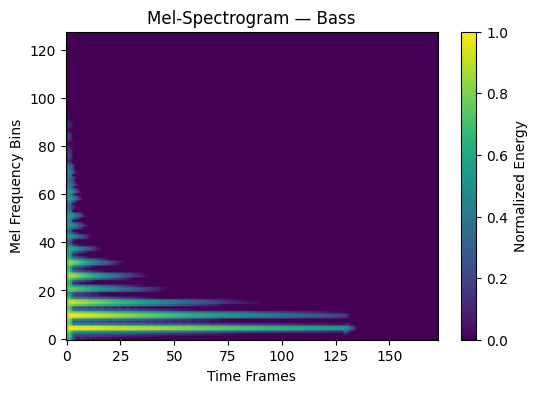

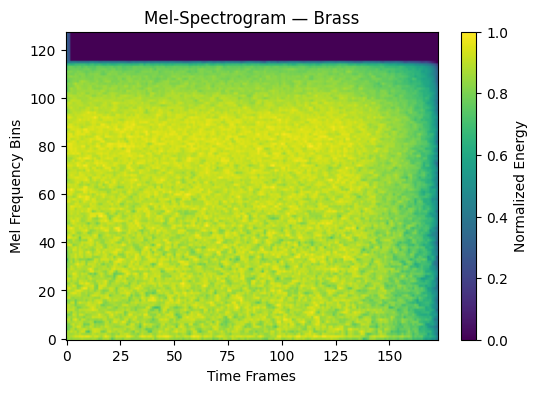

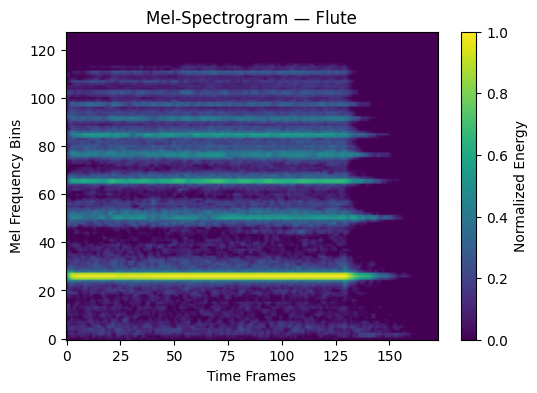

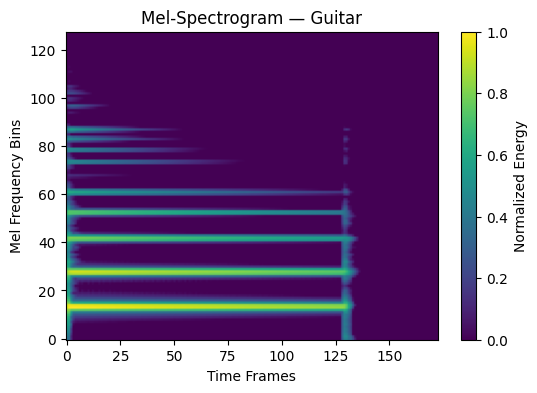

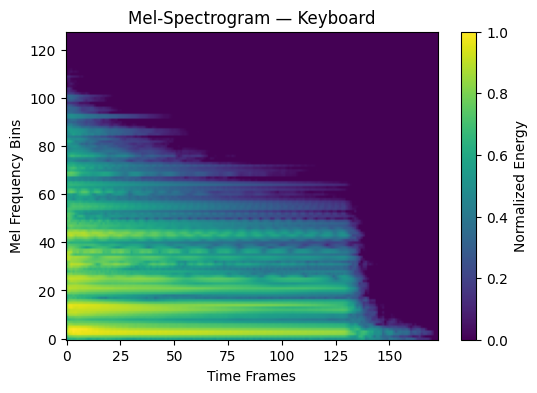

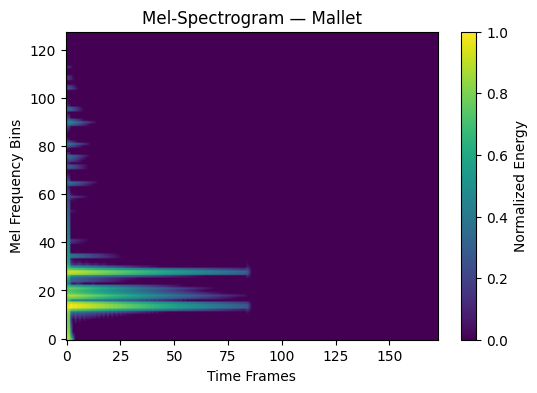

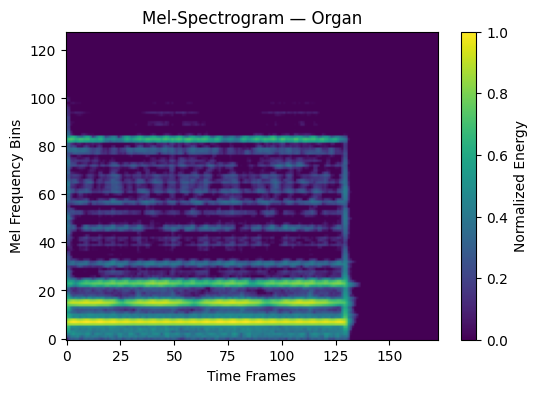

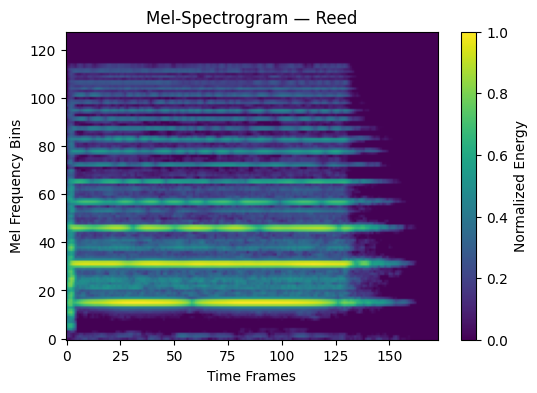

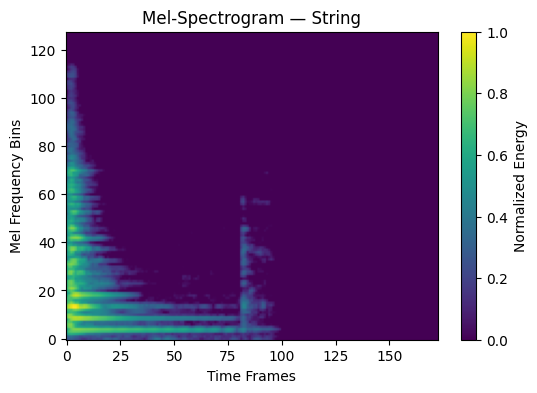

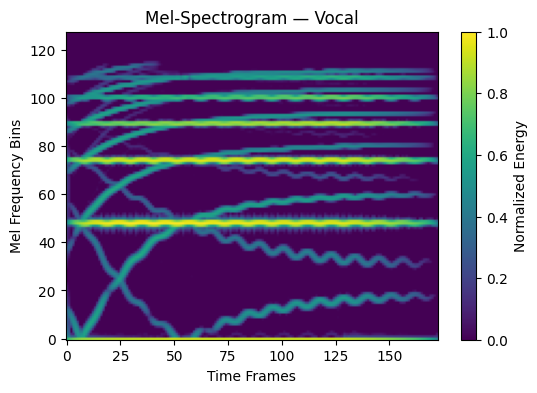

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt

OUT_DIR = "/content/drive/MyDrive/InstruNet_project/Class_Spectrograms"
os.makedirs(OUT_DIR, exist_ok=True)

for cls_idx, cls_name in enumerate(classes):
    # pick first sample of that class
    idx = np.where(y_balanced == cls_idx)[0][0]
    spec = X_balanced[idx].squeeze()

    plt.figure(figsize=(6,4))
    plt.imshow(spec, aspect="auto", origin="lower", cmap="viridis")
    plt.colorbar(label="Normalized Energy")
    plt.title(f"Mel-Spectrogram — {cls_name.capitalize()}")
    plt.xlabel("Time Frames")
    plt.ylabel("Mel Frequency Bins")

    # save
    save_path = os.path.join(OUT_DIR, f"{cls_name}.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()
    plt.close()


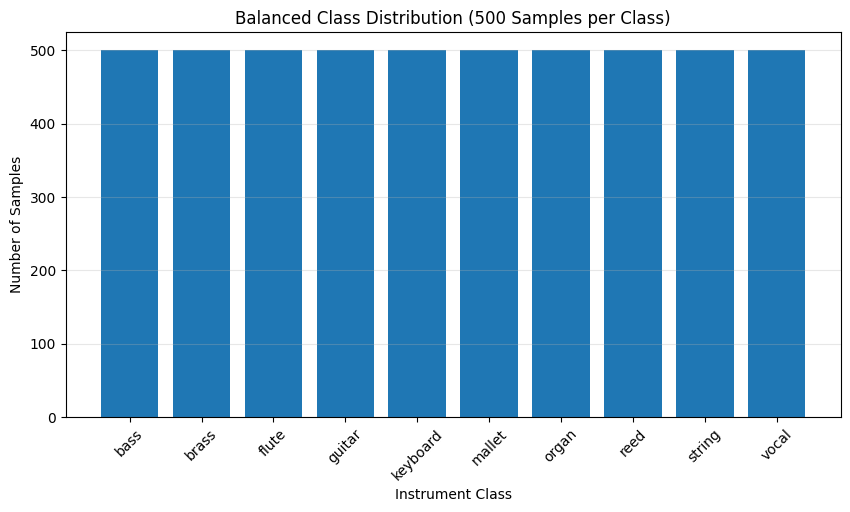

In [8]:
import matplotlib.pyplot as plt
from collections import Counter

counts = Counter(y_balanced)

plt.figure(figsize=(10,5))
plt.bar([classes[i] for i in counts.keys()], counts.values())
plt.xticks(rotation=45)
plt.ylabel("Number of Samples")
plt.xlabel("Instrument Class")
plt.title("Balanced Class Distribution (500 Samples per Class)")
plt.grid(axis="y", alpha=0.3)
plt.show()


**Milestone-2**

Week 3–4: CNN Model Development
• Build CNN architecture for instrument classification.
• Train model on preprocessed spectrogram dataset.
• Milestone: Initial CNN model achieves baseline accuracy.


In [9]:
import numpy as np

BASE_PATH = "/content/drive/MyDrive/InstruNet_project"

X = np.load(BASE_PATH + "/X_balanced_500.npy")
y = np.load(BASE_PATH + "/y_balanced_500.npy")
classes = np.load(BASE_PATH + "/classes.npy", allow_pickle=True)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Classes:", classes)


X shape: (5000, 128, 173, 1)
y shape: (5000,)
Classes: ['bass' 'brass' 'flute' 'guitar' 'keyboard' 'mallet' 'organ' 'reed'
 'string' 'vocal']


In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

NUM_CLASSES = len(classes)

y_cat = to_categorical(y, NUM_CLASSES)

# 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_cat,
    test_size=0.30,
    stratify=y,
    random_state=42
)

# Split temp → 15% val, 15% test
y_temp_labels = np.argmax(y_temp, axis=1)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp_labels,
    random_state=42
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)


Train: (3500, 128, 173, 1)
Validation: (750, 128, 173, 1)
Test: (750, 128, 173, 1)


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=X_train.shape[1:]),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 171, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 171, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 83, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 83, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 41, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 39, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 39, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 34048)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,716,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,812,682 (33.62 MB)

 Trainable params: 8,812,234 (33.62 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - accuracy: 0.3405 - loss: 8.5676 - val_accuracy: 0.1013 - val_loss: 37.1238
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5233 - loss: 2.2448 - val_accuracy: 0.1013 - val_loss: 44.6488
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6103 - loss: 1.2776 - val_accuracy: 0.1907 - val_loss: 41.9878
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7051 - loss: 0.8494 - val_accuracy: 0.2973 - val_loss: 16.3894
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7333 - loss: 0.8054 - val_accuracy: 0.6227 - val_loss: 1.7741
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7518 - loss: 0.7051 - val_accuracy: 0.8080 - val_loss: 0.9704
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7893 - loss: 0.6253 - val_accuracy: 0.8907 - val_loss: 0.3443
Epoch 8/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.7990 - loss: 0.6153 - val

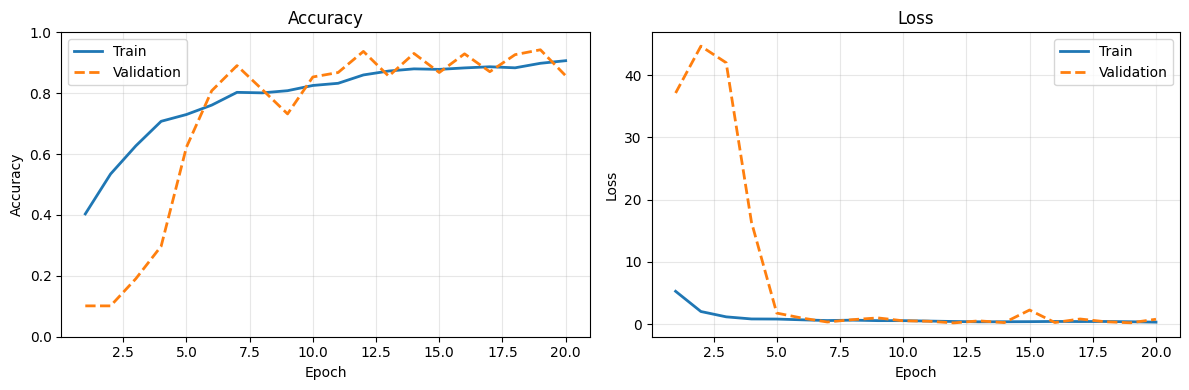

Model saved


In [14]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)

print(f"Validation Loss     : {val_loss:.4f}")
print(f"Validation Accuracy : {val_accuracy:.4f}")

print(f"Test Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy:.4f}")
from sklearn.metrics import precision_score, recall_score, f1_score

y_test_pred = np.argmax(model.predict(X_test), axis=1)
y_test_true = np.argmax(y_test, axis=1)

precision = precision_score(y_test_true, y_test_pred, average='macro')
recall = recall_score(y_test_true, y_test_pred, average='macro')
f1 = f1_score(y_test_true, y_test_pred, average='macro')

print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, history.history['accuracy'], label='Train', linewidth=2)
plt.plot(epochs, history.history['val_accuracy'], label='Validation', linestyle='--', linewidth=2)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.plot(epochs, history.history['loss'], label='Train', linewidth=2)
plt.plot(epochs, history.history['val_loss'], label='Validation', linestyle='--', linewidth=2)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
model.save(BASE_PATH + "/cnn_instrument_model.h5")
print("Model saved")


In [15]:
import numpy as np

y_test_probs = model.predict(X_test)
y_test_pred = np.argmax(y_test_probs, axis=1)
y_test_true = np.argmax(y_test, axis=1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


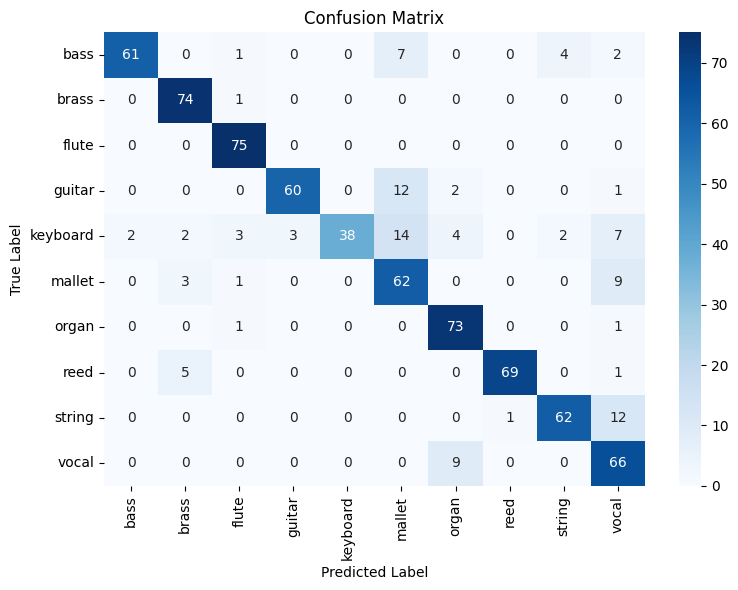

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test_true, y_test_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [18]:
from sklearn.metrics import classification_report

report = classification_report(
    y_test_true,
    y_test_pred,
    target_names=classes
)

print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

        bass       0.97      0.81      0.88        75
       brass       0.88      0.99      0.93        75
       flute       0.91      1.00      0.96        75
      guitar       0.95      0.80      0.87        75
    keyboard       1.00      0.51      0.67        75
      mallet       0.65      0.83      0.73        75
       organ       0.83      0.97      0.90        75
        reed       0.99      0.92      0.95        75
      string       0.91      0.83      0.87        75
       vocal       0.67      0.88      0.76        75

    accuracy                           0.85       750
   macro avg       0.88      0.85      0.85       750
weighted avg       0.88      0.85      0.85       750

